# Select virtual datacube

(Utiliser l'environnement *data-env*)

L'objectif est d'extraire des cubes de données autour d'un ensemble de points d'observations à partir d'un datacube (time, lon, lat).

## Configuration

### Librairies

In [1]:
import sys
import time
from pathlib import Path
from datetime import datetime, timedelta
from time import time 

import intake
import numpy as np
import pandas as pd
import xarray as xr
from dask.distributed import LocalCluster, Client
from IPython.display import display

sys.path.insert(0, '../..')
from histlib.observations import (
    generate_virtual_observations,
    plot_observations,
)
from histlib.datacube import generate_virtual_datacube

In [2]:
# Choisir l'extension spatiale/temporelle de la zone d'étude
extent = (-180, 180, -90, 90) # Extension spatiale (lon_min, lon_max, lat_min, lat_max)
period = ('2000-01-01', '2001-01-01') # Extension temporelle (start_date, end_date)

## Observations

In [3]:
N = 1000 # Nombre de points d'observations

In [4]:
# Génération des points d'observations
ds = generate_virtual_observations(N, extent, period)

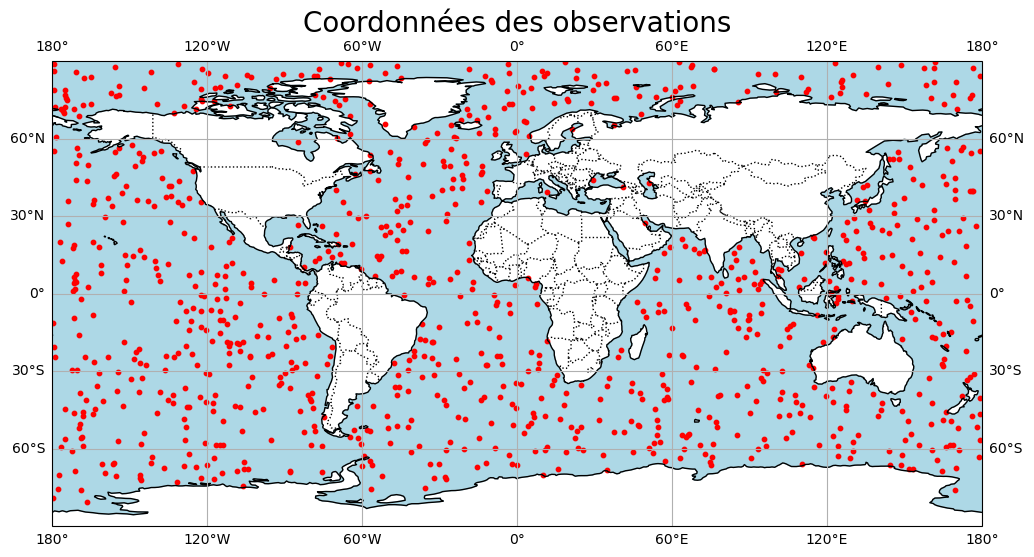

In [5]:
# Affichage sur une carte
plot_observations(ds)

## Datacube

In [6]:
%%time
# Génération du datacube
datacube = generate_virtual_datacube(extent, period)

CPU times: user 15.6 s, sys: 1.12 s, total: 16.8 s
Wall time: 16.7 s


In [7]:
datacube

<xarray.Dataset>
Dimensions:  (time: 367, lat: 720, lon: 1440)
Coordinates:
  * lat      (lat) float64 -90.0 -89.75 -89.5 -89.25 ... 89.25 89.5 89.75 90.0
  * lon      (lon) float64 -180.0 -179.7 -179.5 -179.2 ... 179.5 179.7 180.0
  * time     (time) datetime64[ns] 2000-01-01 2000-01-02 ... 2001-01-01
Data variables:
    data     (time, lat, lon) float64 -0.546 -1.231 -0.4819 ... 0.06437 0.1539

## Select points

Avant de sélectionner des cubes on commence par sélectionner les valeurs les plus proches des points d'observations. 

In [8]:
# Selection dans le datacube
result = datacube.sel(
    time=ds.time,
    lon=ds.lon,
    lat=ds.lat,
    method="nearest",
)

In [9]:
result

<xarray.Dataset>
Dimensions:  (obs: 1000)
Coordinates:
    lat      (obs) float64 -63.71 0.8762 -42.18 49.44 ... -65.97 -6.384 10.39
    lon      (obs) float64 129.0 -152.2 -117.5 -26.14 ... -156.5 82.18 82.68
    time     (obs) datetime64[ns] 2000-02-02 2000-01-05 ... 2000-11-16
  * obs      (obs) int64 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999
Data variables:
    data     (obs) float64 1.622 0.06177 0.1346 ... -0.3552 -0.06683 0.5107

## Select cubes

Après avoir vérifier que la sélection de points fonctionne, on passe à la sélection de cube, de 2 manières différentes (séquentielle, et vectorielle)

In [10]:
# Définition des paramètres
dt, dlon, dlat = 2, 5, 5 # +/- dt jours, +/- dlon° de longitude, +/- dlat° de latitude
dl = 0.25 # le pas spatial (entre 2 valeurs de longitude)

### 1) Séquentielle

Ici, on parcours les observations les unes après les autres en selectionnant le cube au sein du datacube.

In [11]:
%%time
results = []
# Génération des slices des cubes à partir des observations, et sélection dans le datacube
for idx, obs in enumerate(ds.obs):
    
    #display(f"{idx+1}/{len(ds.obs)}", clear=True)
    
    start, end = obs.time + pd.Timedelta(days=-dt), obs.time + pd.Timedelta(days=dt)
    lon_min, lon_max = obs.lon - dlon, obs.lon + dlon
    lat_min, lat_max = obs.lat - dlat, obs.lat + dlat
    
    # Sélection d'un cube au sein du datacube
    results.append(
        datacube.sel(
            time=slice(start, end),
            lon=slice(lon_min, lon_max),
            lat=slice(lat_min, lat_max),
        )
    )

CPU times: user 1.64 s, sys: 12 ms, total: 1.66 s
Wall time: 1.67 s


### 2) Vectorielle

Ici, on sélectionne les cubes de chaque observations en une seul fois, 

#### a) Same shape cubes (2D arrays)

In [12]:
%%time
# Génération des index des cubes à partir des observations
i_time, i_lon, i_lat = [], [] ,[]
for idx, obs in enumerate(ds.obs):
    
    #display(f"{idx+1}/{len(ds.obs)}", clear=True)
        
    start, end = obs.time + pd.Timedelta(days=-dt), obs.time + pd.Timedelta(days=dt+1)
    lon_min, lon_max = obs.lon - dlon, obs.lon + dlon
    lat_min, lat_max = obs.lat - dlat, obs.lat + dlat

    i_lon.append(np.linspace(lon_min, lon_max, 40))
    i_lat.append(np.linspace(lat_min, lat_max, 40))
    #i_lon.append(np.r_[slice(lon_min, lon_max, dl)])
    #i_lat.append(np.r_[slice(lat_min, lat_max, dl)])
    i_time.append(np.r_[slice(start.values, end.values, timedelta(days=1))])

CPU times: user 1.3 s, sys: 16 ms, total: 1.31 s
Wall time: 1.3 s


In [13]:
%%time
# Sélection dans le datacube
result = datacube.sel(
    time=xr.DataArray(i_time,  dims=["obs", "t"]),
    lon=xr.DataArray(i_lon,  dims=["obs", "x"]),
    lat=xr.DataArray(i_lat,  dims=["obs", "y"]),
    method="nearest",
)

CPU times: user 112 ms, sys: 24 ms, total: 136 ms
Wall time: 136 ms


In [13]:
result

<xarray.Dataset>
Dimensions:  (obs: 1000, t: 5, y: 40, x: 40)
Coordinates:
    lat      (obs, y) float64 -65.72 -65.47 -65.22 ... -51.45 -51.2 -50.95
    lon      (obs, x) float64 -110.7 -110.5 -110.2 -110.0 ... 86.69 86.94 87.19
    time     (obs, t) datetime64[ns] 2000-09-20 2000-09-21 ... 2000-12-06
Dimensions without coordinates: obs, t, y, x
Data variables:
    data     (obs, t, y, x) float64 -0.104 1.806 0.583 ... 0.05283 0.08613

#### b) Different shape cubes (1D flatten arrays)

In [14]:
%%time
# Génération des slices des cubes à partir des observations
s_time, s_lat, s_lon = [], [] , []
for idx, obs in enumerate(ds.obs):
    
    #display(f"{idx+1}/{len(ds.obs)}", clear=True)
    
    start, end = obs.time + pd.Timedelta(days=-dt), obs.time + pd.Timedelta(days=dt)
    lon_min, lon_max = obs.lon - dlon, obs.lon + dlon
    lat_min, lat_max = obs.lat - dlat, obs.lat + dlat
    
    s_time.append(slice(start.values, end.values + pd.Timedelta(days=1), timedelta(days=1)))
    s_lat.append(slice(lat_min, lat_max, dl))
    s_lon.append(slice(lon_min, lon_max, dl))

CPU times: user 1.01 s, sys: 0 ns, total: 1.01 s
Wall time: 1 s


In [15]:
%%time
# Génération des listes d'indices à plat à partir des slices
f_time, f_lat, f_lon = [], [], []
pos, shapes = [], []
n=0
for st, sla, slo in zip(s_time, s_lat, s_lon):
    
    # Générer les indices pour chaque dimension de l'observation en cours
    it = np.r_[st]
    ila = np.r_[sla]
    ilo = np.r_[slo]

    # Créer des grilles multidimensionnelles
    gt, gla, glo = np.meshgrid(it, ila, ilo, indexing='ij')

    # Mise à plat des indices
    ft = gt.flatten()
    fla = gla.flatten()
    flo = glo.flatten()

    # Ajouter les indices à plat du cube, dans la liste des indices à plat
    f_time.extend(ft)
    f_lat.extend(fla)
    f_lon.extend(flo)

    # Enregistre la dimension du cube
    shapes.append((len(it), len(ila), len(ilo)))
    
    # Enregistre les indices correspondant au cube
    n1 = n + len(ft)
    pos.append(slice(n, n1))       
    n = n1

CPU times: user 3.91 s, sys: 376 ms, total: 4.28 s
Wall time: 4.28 s


In [16]:
%%time
# Sélection dans le datacube
result = datacube.sel(
    time=xr.DataArray(f_time,  dims="points"),
    lon=xr.DataArray(f_lon,  dims="points"),
    lat=xr.DataArray(f_lat,  dims="points"),
    method="nearest",
)

CPU times: user 5.64 s, sys: 1.29 s, total: 6.93 s
Wall time: 6.92 s


In [17]:
result

<xarray.Dataset>
Dimensions:  (points: 8001800)
Coordinates:
    lat      (points) float64 -68.72 -68.72 -68.72 -68.72 ... 15.15 15.15 15.15
    lon      (points) float64 124.0 124.2 124.5 124.7 ... 86.94 87.19 87.44
    time     (points) datetime64[ns] 2000-01-31 2000-01-31 ... 2000-11-18
Dimensions without coordinates: points
Data variables:
    data     (points) float64 -0.2525 -0.8544 -0.412 ... -1.541 0.2661 1.051

In [18]:
%%time
# A partir de la liste unique on récupère les listes de valeurs de chaque observation
arrs = []
for p in pos:
    arrs.append(result.sel(points=p))

CPU times: user 184 ms, sys: 4 ms, total: 188 ms
Wall time: 189 ms


In [19]:
%%time
# Pour chaque cube on remet en forme le cube
results = []
for idx, (arr, shape) in enumerate(zip(arrs, shapes)):
    dsa_time = np.r_[s_time[idx]]
    dsa_lat = np.r_[s_lat[idx]]
    dsa_lon = np.r_[s_lon[idx]]
    dsa_data = arr.data.values.reshape(shape)
    results.append(xr.Dataset(
            data_vars=dict(data=(['time', 'lat', 'lon'], dsa_data)),
            coords=dict(
                lat=dsa_lat,
                lon=dsa_lon,
                time=dsa_time,
            )
        )
    )

CPU times: user 3.83 s, sys: 8 ms, total: 3.84 s
Wall time: 3.82 s


In [20]:
results[63]

<xarray.Dataset>
Dimensions:  (time: 5, lat: 40, lon: 40)
Coordinates:
  * lat      (lat) float64 4.755 5.005 5.255 5.505 ... 13.76 14.01 14.26 14.51
  * lon      (lon) float64 -144.7 -144.4 -144.2 -143.9 ... -135.4 -135.2 -134.9
  * time     (time) datetime64[ns] 2000-08-18 2000-08-19 ... 2000-08-22
Data variables:
    data     (time, lat, lon) float64 2.403 -0.1243 1.635 ... -0.5146 0.04514